In [ ]:
import torch
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Carga y preprocesado de datos

import torchvision.datasets as datasets
import torchvision.transforms as transforms

tam_batch = 64

train_dataset = datasets.MNIST(
    root = './datos',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = tam_batch,
    shuffle = True
)

test_dataset = datasets.MNIST(
    root = './datos',
    train = False,
    transform = transforms.ToTensor(),
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = tam_batch,
    shuffle = False
)




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16513802.74it/s]


Extracting ./datos/MNIST/raw/train-images-idx3-ubyte.gz to ./datos/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490898.93it/s]


Extracting ./datos/MNIST/raw/train-labels-idx1-ubyte.gz to ./datos/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4483812.96it/s]


Extracting ./datos/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datos/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9829994.20it/s]

Extracting ./datos/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datos/MNIST/raw



Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de test: 10000
Tamaño de las imagenes: torch.Size([64, 1, 28, 28]) 



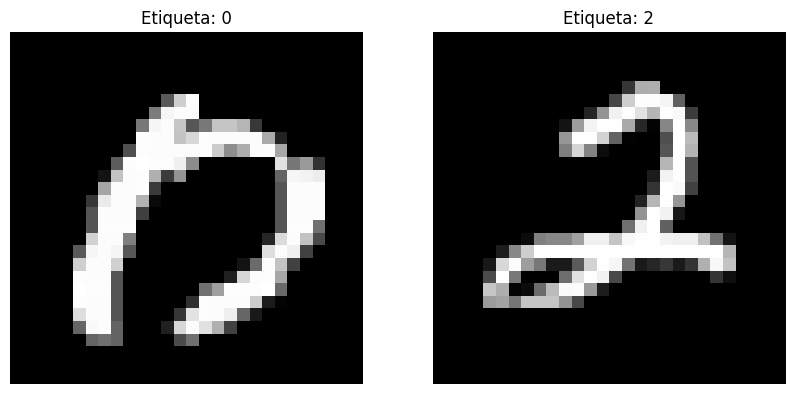

In [ ]:
# Visualización de los datos

import matplotlib.pyplot as plt
import numpy as np

print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset.data)}')
print(f'Tamaño del conjunto de test: {len(test_dataset.data)}')

imagenes, etiquetas = next(iter(train_loader))
print(f'Tamaño de las imagenes: {imagenes.shape} \n')

fig,axs = plt.subplots(1,2,figsize=(10,10))
for i in range(2):
  axs[i].imshow(np.squeeze(imagenes[i]),cmap='gray')
  axs[i].set_title(f'Etiqueta: {etiquetas[i]}')
  axs[i].axis('off')
plt.show()

In [ ]:
#Implementación CNN

import torch.nn as nn

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    #Extracción de características
    self.conv1 = nn.Conv2d(1,6,kernel_size=5,padding='same')
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(6,16,kernel_size=5,padding='same')
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    #Clasificador de carácterísticas
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(16 * 7 * 7, 120)
    self.lin2 = nn.Linear(120, 84)
    self.lin3 = nn.Linear(84, 10)

    #Activación
    self.relu = nn.ReLU()

  def forward(self,x):
    x = self.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.relu(self.lin1(x))
    x = self.relu(self.lin2(x))
    y = self.lin3(x)

    return y

modelo = CNN()
modelo.to(dispositivo)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=784, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
def epoca_train(
    modelo,train_loader,optimizador,func_perdida,dispositivo):
  epoca_perdidas = []
  for i, (imagenes,etiquetas) in enumerate(train_loader):
    imagenes = imagenes.to(dispositivo)
    etiquetas = etiquetas.to(dispositivo)
    optimizador.zero_grad()
    salidas = modelo(imagenes)
    perdida = func_perdida(salidas,etiquetas)
    perdida.backward()
    optimizador.step()
    epoca_perdidas.append(perdida.item())

  return sum(epoca_perdidas) / len(epoca_perdidas)

In [ ]:
def epoca_test(modelo,test_loader,dispositivo):
  modelo.eval()
  with torch.no_grad():
    correcto = 0
    total = 0
    for imagenes,etiquetas in test_loader:
      imagenes = imagenes.to(dispositivo)
      etiquetas = etiquetas.to(dispositivo)
      salidas = modelo(imagenes)
      salidas = salidas.softmax(dim=1)
      prediccion = salidas.argmax(dim=1)
      total += etiquetas.size(0)
      correcto += (prediccion == etiquetas).sum().item()

    exactitud = 100 * correcto / total
  modelo.train()
  return exactitud

In [ ]:
#Entrenamiento

import torch.optim as optim

optimizador = optim.Adam(modelo.parameters())
func_perdida = nn.CrossEntropyLoss()
train_accs = []
test_accs = []
perdida = []
epocas = 15

for epoca in range(epocas):
  train_perdida = epoca_train(
      modelo, train_loader, optimizador, func_perdida, dispositivo)
  perdida.append(train_perdida)
  train_acc = epoca_test(modelo, train_loader, dispositivo)
  train_accs.append(train_acc)
  test_acc = epoca_test(modelo, test_loader, dispositivo)
  test_accs.append(test_acc)
  print(f'Época {epoca + 1} / {epocas},\
        pérdida = {train_perdida:.4f},\
        exactitud_train = {train_acc:.2f}%,\
        exactitud_test = {test_acc:.2f}%')
  print('Fin del entrenamiento')

Época 1 / 15,        pérdida = 0.2726,        exactitud_train = 97.60%,        exactitud_test = 98.01%
Fin del entrenamiento
Época 2 / 15,        pérdida = 0.0698,        exactitud_train = 98.43%,        exactitud_test = 98.39%
Fin del entrenamiento
Época 3 / 15,        pérdida = 0.0505,        exactitud_train = 98.88%,        exactitud_test = 98.62%
Fin del entrenamiento
Época 4 / 15,        pérdida = 0.0387,        exactitud_train = 98.97%,        exactitud_test = 98.61%
Fin del entrenamiento
Época 5 / 15,        pérdida = 0.0316,        exactitud_train = 99.35%,        exactitud_test = 98.97%
Fin del entrenamiento
Época 6 / 15,        pérdida = 0.0255,        exactitud_train = 99.19%,        exactitud_test = 98.74%
Fin del entrenamiento
Época 7 / 15,        pérdida = 0.0221,        exactitud_train = 99.33%,        exactitud_test = 98.77%
Fin del entrenamiento
Época 8 / 15,        pérdida = 0.0196,        exactitud_train = 99.47%,        exactitud_test = 98.96%
Fin del entrenamiento


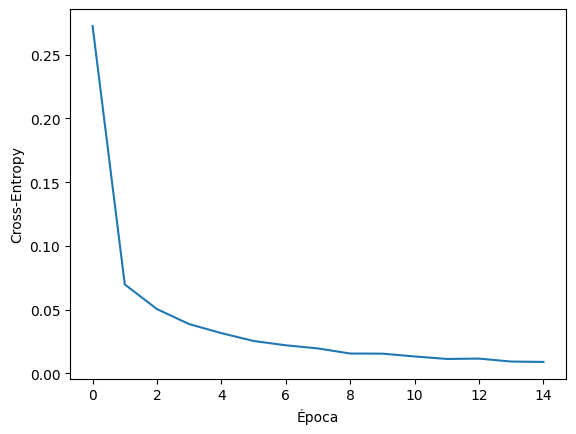

In [ ]:
# Cross-Entropy

plt.plot(perdida)
plt.xlabel('Época')
plt.ylabel('Cross-Entropy')
plt.show()

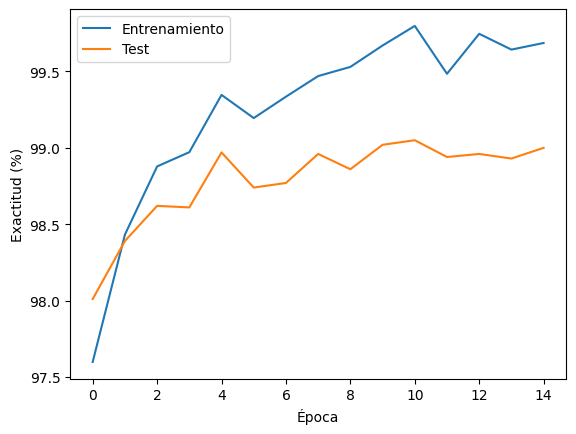

In [ ]:
# Evaluación del modelo

plt.plot(train_accs)
plt.plot(test_accs)
plt.xlabel('Época')
plt.ylabel('Exactitud (%)')
plt.legend(['Entrenamiento','Test'])
plt.show()

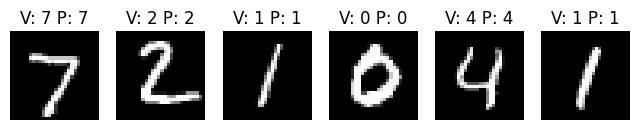

In [ ]:
#Resultados y conclusiones

imagenes, etiquetas = next(iter(test_loader))
with torch.no_grad():
    imagenes = imagenes.to(dispositivo)
    etiquetas = etiquetas.to(dispositivo)
    salidas = modelo(imagenes)
    salidas = salidas.softmax(dim=1)
    predicciones = salidas.argmax(dim=1)

fig, axs = plt.subplots(1, 6, figsize=(8, 8))
for i in range(6):
    axs[i].imshow(np.squeeze(imagenes[i].cpu()), cmap='gray')
    axs[i].set_title(f'V: {etiquetas[i]} P: {predicciones[i]}')
    axs[i].axis('off')
plt.show()
